<a href="https://colab.research.google.com/github/diegorabelorn/IA/blob/main/IA_Parte3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Módulo 1: dados_opt.py

Padronizar os dados é crucial, pois algoritmos baseados em distância/vetores (como PSO) falham se as escalas forem muito diferentes (ex: Renda vs Quantidade de Quartos).

In [1]:
# dados_opt.py
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def carregar_dados_otimizacao():
    """Carrega e padroniza o dataset California Housing."""
    data = fetch_california_housing()
    X = data.data
    y = data.target

    # Divisão Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Padronização (StandardScaler) - CRUCIAL para GA e PSO convergirem
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Adicionar coluna de bias (1s) para simplificar o cálculo y = wx + b
    # O bias vira apenas mais um peso w0
    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    return X_train, X_test, y_train, y_test

def calcular_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calcular_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

Módulo 2: ga_opt.py (Algoritmo Genético)

Implementação focada em Codificação Real (já que buscamos pesos numéricos, não binários).

In [2]:
# ga_opt.py
import numpy as np
import random

class GeneticAlgorithm:
    def __init__(self, pop_size, mutation_rate, crossover_rate, n_genes, fun_avaliacao):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.n_genes = n_genes
        self.fun_avaliacao = fun_avaliacao # Função (MSE ou MAE)
        self.population = []
        self.best_individual = None
        self.best_score = float('inf')
        self.history = []

    def init_population(self):
        # Inicializa pesos aleatórios entre -1 e 1
        self.population = np.random.uniform(-1, 1, (self.pop_size, self.n_genes))

    def fitness(self, individuo, X, y):
        # Predição: y_pred = X dot w
        y_pred = X.dot(individuo)
        return self.fun_avaliacao(y, y_pred)

    def select(self, scores):
        # Seleção por Torneio
        idx1 = random.randint(0, self.pop_size - 1)
        idx2 = random.randint(0, self.pop_size - 1)
        if scores[idx1] < scores[idx2]: # Menor erro é melhor
            return self.population[idx1]
        return self.population[idx2]

    def crossover(self, pai1, pai2):
        if random.random() < self.crossover_rate:
            # Crossover de um ponto
            point = random.randint(1, self.n_genes - 1)
            filho1 = np.concatenate([pai1[:point], pai2[point:]])
            filho2 = np.concatenate([pai2[:point], pai1[point:]])
            return filho1, filho2
        return pai1.copy(), pai2.copy()

    def mutate(self, individuo):
        for i in range(self.n_genes):
            if random.random() < self.mutation_rate:
                # Mutação Gaussiana (adiciona ruído)
                individuo[i] += np.random.normal(0, 0.1)
        return individuo

    def run(self, X, y, generations=50):
        self.init_population()

        for generation in range(generations):
            scores = [self.fitness(ind, X, y) for ind in self.population]

            # Guardar melhor
            min_score = min(scores)
            if min_score < self.best_score:
                self.best_score = min_score
                self.best_individual = self.population[scores.index(min_score)].copy()

            self.history.append(self.best_score)

            new_pop = []
            # Elitismo: mantém o melhor
            new_pop.append(self.best_individual)

            while len(new_pop) < self.pop_size:
                pai1 = self.select(scores)
                pai2 = self.select(scores)
                filho1, filho2 = self.crossover(pai1, pai2)
                new_pop.append(self.mutate(filho1))
                if len(new_pop) < self.pop_size:
                    new_pop.append(self.mutate(filho2))

            self.population = np.array(new_pop)

        return self.best_score, self.best_individual

Módulo 3: pso_opt.py (Otimização por Enxame de Partículas)

Implementação vetorial do PSO.

In [3]:
# pso_opt.py
import numpy as np

class PSO:
    def __init__(self, n_particles, c1, c2, n_dim, fun_avaliacao, w=0.7):
        self.n_particles = n_particles
        self.c1 = c1 # Cognitivo
        self.c2 = c2 # Social
        self.w = w   # Inércia
        self.n_dim = n_dim
        self.fun_avaliacao = fun_avaliacao

        # Posições e Velocidades
        self.positions = np.random.uniform(-1, 1, (n_particles, n_dim))
        self.velocities = np.zeros((n_particles, n_dim))

        # Melhores Pessoais (pBest) e Global (gBest)
        self.p_best_pos = self.positions.copy()
        self.p_best_scores = np.full(n_particles, float('inf'))
        self.g_best_pos = None
        self.g_best_score = float('inf')
        self.history = []

    def run(self, X, y, iterations=50):
        # Avaliação Inicial
        for i in range(self.n_particles):
            y_pred = X.dot(self.positions[i])
            score = self.fun_avaliacao(y, y_pred)

            if score < self.p_best_scores[i]:
                self.p_best_scores[i] = score
                self.p_best_pos[i] = self.positions[i]

            if score < self.g_best_score:
                self.g_best_score = score
                self.g_best_pos = self.positions[i]

        # Loop Principal
        for it in range(iterations):
            for i in range(self.n_particles):
                # Randomness
                r1 = np.random.random(self.n_dim)
                r2 = np.random.random(self.n_dim)

                # Atualizar Velocidade
                # v = w*v + c1*r1*(pBest - x) + c2*r2*(gBest - x)
                cognitive = self.c1 * r1 * (self.p_best_pos[i] - self.positions[i])
                social = self.c2 * r2 * (self.g_best_pos - self.positions[i])
                self.velocities[i] = self.w * self.velocities[i] + cognitive + social

                # Atualizar Posição
                self.positions[i] += self.velocities[i]

                # Avaliar nova posição
                y_pred = X.dot(self.positions[i])
                score = self.fun_avaliacao(y, y_pred)

                if score < self.p_best_scores[i]:
                    self.p_best_scores[i] = score
                    self.p_best_pos[i] = self.positions[i]

                if score < self.g_best_score:
                    self.g_best_score = score
                    self.g_best_pos = self.positions[i]

            self.history.append(self.g_best_score)

        return self.g_best_score, self.g_best_pos

Módulo 4: principal_opt.py (Experimentos e Comparação)

Este módulo define os 8 experimentos, escolhe as duas funções de avaliação (MSE e MAE) e compara os resultados.

In [5]:
import numpy as np
import pandas as pd
import random
import time
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ====================================================================
# 1. MÓDULO DE DADOS (dados_opt)
# ====================================================================

def carregar_dados_otimizacao():
    """Carrega e padroniza o dataset California Housing."""
    data = fetch_california_housing()
    X = data.data
    y = data.target

    # Divisão Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Padronização (StandardScaler) - CRUCIAL para algoritmos de otimização
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Adicionar coluna de bias (1s) para o cálculo y = wx + b
    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    return X_train, X_test, y_train, y_test

def calcular_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calcular_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# ====================================================================
# 2. MÓDULO ALGORITMO GENÉTICO (ga_opt)
# ====================================================================

class GeneticAlgorithm:
    def __init__(self, pop_size, mutation_rate, crossover_rate, n_genes, fun_avaliacao):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.n_genes = n_genes
        self.fun_avaliacao = fun_avaliacao # Função (MSE ou MAE)
        self.population = []
        self.best_individual = None
        self.best_score = float('inf')
        self.history = []

    def init_population(self):
        # Inicializa pesos aleatórios entre -1 e 1
        self.population = np.random.uniform(-1, 1, (self.pop_size, self.n_genes))

    def fitness(self, individuo, X, y):
        # Predição: y_pred = X dot w
        y_pred = X.dot(individuo)
        return self.fun_avaliacao(y, y_pred)

    def select(self, scores):
        # Seleção por Torneio
        idx1 = random.randint(0, self.pop_size - 1)
        idx2 = random.randint(0, self.pop_size - 1)
        if scores[idx1] < scores[idx2]: # Menor erro é melhor
            return self.population[idx1]
        return self.population[idx2]

    def crossover(self, pai1, pai2):
        if random.random() < self.crossover_rate:
            # Crossover de um ponto
            point = random.randint(1, self.n_genes - 1)
            filho1 = np.concatenate([pai1[:point], pai2[point:]])
            filho2 = np.concatenate([pai2[:point], pai1[point:]])
            return filho1, filho2
        return pai1.copy(), pai2.copy()

    def mutate(self, individuo):
        for i in range(self.n_genes):
            if random.random() < self.mutation_rate:
                # Mutação Gaussiana (adiciona ruído)
                individuo[i] += np.random.normal(0, 0.1)
        return individuo

    def run(self, X, y, generations=50):
        self.init_population()
        self.best_score = float('inf') # Reinicia para cada run

        for generation in range(generations):
            scores = [self.fitness(ind, X, y) for ind in self.population]

            # Guardar melhor
            min_score = min(scores)
            if min_score < self.best_score:
                self.best_score = min_score
                self.best_individual = self.population[scores.index(min_score)].copy()

            self.history.append(self.best_score)

            new_pop = []
            # Elitismo: mantém o melhor da geração anterior
            new_pop.append(self.best_individual)

            while len(new_pop) < self.pop_size:
                pai1 = self.select(scores)
                pai2 = self.select(scores)
                filho1, filho2 = self.crossover(pai1, pai2)
                new_pop.append(self.mutate(filho1))
                if len(new_pop) < self.pop_size:
                    new_pop.append(self.mutate(filho2))

            self.population = np.array(new_pop)

        return self.best_score, self.best_individual

# ====================================================================
# 3. MÓDULO PSO (pso_opt)
# ====================================================================

class PSO:
    def __init__(self, n_particles, c1, c2, n_dim, fun_avaliacao, w=0.7):
        self.n_particles = n_particles
        self.c1 = c1 # Cognitivo
        self.c2 = c2 # Social
        self.w = w   # Inércia
        self.n_dim = n_dim
        self.fun_avaliacao = fun_avaliacao

        # Posições e Velocidades
        self.positions = np.random.uniform(-1, 1, (n_particles, n_dim))
        self.velocities = np.zeros((n_particles, n_dim))

        # Melhores Pessoais (pBest) e Global (gBest)
        self.p_best_pos = self.positions.copy()
        self.p_best_scores = np.full(n_particles, float('inf'))
        self.g_best_pos = None
        self.g_best_score = float('inf')
        self.history = []

    def run(self, X, y, iterations=50):
        # Avaliação Inicial
        for i in range(self.n_particles):
            y_pred = X.dot(self.positions[i])
            score = self.fun_avaliacao(y, y_pred)

            if score < self.p_best_scores[i]:
                self.p_best_scores[i] = score
                self.p_best_pos[i] = self.positions[i]

            if score < self.g_best_score:
                self.g_best_score = score
                self.g_best_pos = self.positions[i]

        # Loop Principal
        for it in range(iterations):
            for i in range(self.n_particles):
                # Aleatoriedade estocástica
                r1 = np.random.random(self.n_dim)
                r2 = np.random.random(self.n_dim)

                # Atualizar Velocidade
                # v = w*v + c1*r1*(pBest - x) + c2*r2*(gBest - x)
                cognitive = self.c1 * r1 * (self.p_best_pos[i] - self.positions[i])
                social = self.c2 * r2 * (self.g_best_pos - self.positions[i])
                self.velocities[i] = self.w * self.velocities[i] + cognitive + social

                # Atualizar Posição
                self.positions[i] += self.velocities[i]

                # Avaliar nova posição
                y_pred = X.dot(self.positions[i])
                score = self.fun_avaliacao(y, y_pred)

                if score < self.p_best_scores[i]:
                    self.p_best_scores[i] = score
                    self.p_best_pos[i] = self.positions[i]

                if score < self.g_best_score:
                    self.g_best_score = score
                    self.g_best_pos = self.positions[i]

            self.history.append(self.g_best_score)

        return self.g_best_score, self.g_best_pos

# ====================================================================
# 4. EXECUÇÃO PRINCIPAL (Experimentos)
# ====================================================================

if __name__ == '__main__':
    print("Carregando dados...")
    # 1. Carregar Dados
    X_train, X_test, y_train, y_test = carregar_dados_otimizacao()
    n_features = X_train.shape[1]

    # 2. Definição das Funções de Avaliação
    funcoes_avaliacao = {
        'MSE': calcular_mse,
        'MAE': calcular_mae
    }

    # 3. Definição dos Experimentos (8 para cada)
    # GA: Varia População, Mutação e Cruzamento
    experimentos_ga = [
        {'id': 1, 'pop': 20, 'mut': 0.01, 'cross': 0.7},
        {'id': 2, 'pop': 20, 'mut': 0.10, 'cross': 0.7},
        {'id': 3, 'pop': 20, 'mut': 0.01, 'cross': 0.9},
        {'id': 4, 'pop': 50, 'mut': 0.01, 'cross': 0.7},
        {'id': 5, 'pop': 50, 'mut': 0.10, 'cross': 0.9},
        {'id': 6, 'pop': 100, 'mut': 0.01, 'cross': 0.8},
        {'id': 7, 'pop': 100, 'mut': 0.05, 'cross': 0.6},
        {'id': 8, 'pop': 10,  'mut': 0.20, 'cross': 0.5}
    ]

    # PSO: Varia População, C1 e C2
    experimentos_pso = [
        {'id': 1, 'pop': 20, 'c1': 1.5, 'c2': 1.5},
        {'id': 2, 'pop': 20, 'c1': 2.0, 'c2': 2.0},
        {'id': 3, 'pop': 20, 'c1': 0.5, 'c2': 2.5},
        {'id': 4, 'pop': 50, 'c1': 1.5, 'c2': 1.5},
        {'id': 5, 'pop': 50, 'c1': 2.5, 'c2': 0.5},
        {'id': 6, 'pop': 100, 'c1': 1.0, 'c2': 1.0},
        {'id': 7, 'pop': 100, 'c1': 1.49, 'c2': 1.49},
        {'id': 8, 'pop': 10,  'c1': 2.0, 'c2': 2.0}
    ]

    resultados = []

    print("\n--- Iniciando Experimentos GA (Algoritmo Genético) ---")
    for func_nome, func_obj in funcoes_avaliacao.items():
        print(f"-> Avaliando com métrica: {func_nome}")
        for exp in experimentos_ga:
            start = time.time()
            ga = GeneticAlgorithm(pop_size=exp['pop'], mutation_rate=exp['mut'],
                                  crossover_rate=exp['cross'], n_genes=n_features,
                                  fun_avaliacao=func_obj)

            # Treino (usando 50 gerações)
            best_score_train, best_weights = ga.run(X_train, y_train, generations=50)
            end = time.time()

            # Teste
            y_pred_test = X_test.dot(best_weights)
            score_test = func_obj(y_test, y_pred_test)

            resultados.append({
                'Algoritmo': 'GA',
                'Metrica': func_nome,
                'Exp_ID': exp['id'],
                'Parametros': f"Pop={exp['pop']}, Mut={exp['mut']}, Cross={exp['cross']}",
                'Score_Treino': best_score_train,
                'Score_Teste': score_test,
                'Tempo(s)': round(end - start, 4)
            })

    print("\n--- Iniciando Experimentos PSO (Enxame de Partículas) ---")
    for func_nome, func_obj in funcoes_avaliacao.items():
        print(f"-> Avaliando com métrica: {func_nome}")
        for exp in experimentos_pso:
            start = time.time()
            pso = PSO(n_particles=exp['pop'], c1=exp['c1'], c2=exp['c2'],
                      n_dim=n_features, fun_avaliacao=func_obj)

            # Treino (usando 50 iterações)
            best_score_train, best_weights = pso.run(X_train, y_train, iterations=50)
            end = time.time()

            # Teste
            y_pred_test = X_test.dot(best_weights)
            score_test = func_obj(y_test, y_pred_test)

            resultados.append({
                'Algoritmo': 'PSO',
                'Metrica': func_nome,
                'Exp_ID': exp['id'],
                'Parametros': f"Pop={exp['pop']}, C1={exp['c1']}, C2={exp['c2']}",
                'Score_Treino': best_score_train,
                'Score_Teste': score_test,
                'Tempo(s)': round(end - start, 4)
            })

    # 5. Exibir Resultados
    df_res = pd.DataFrame(resultados)

    print("\n" + "="*60)
    print("RESUMO COMPARATIVO (Média por Algoritmo)")
    print("="*60)
    print(df_res.groupby(['Algoritmo', 'Metrica'])[['Score_Teste', 'Tempo(s)']].mean())

    print("\n" + "="*60)
    print("MELHOR CONFIGURAÇÃO ENCONTRADA (Menor Erro no Teste)")
    print("="*60)

    # Melhor GA para MSE
    melhor_ga_mse = df_res[(df_res['Algoritmo']=='GA') & (df_res['Metrica']=='MSE')].sort_values('Score_Teste').iloc[0]
    print(f"\n[GA - MSE] Melhor Exp: {melhor_ga_mse['Exp_ID']}")
    print(f"Params: {melhor_ga_mse['Parametros']}")
    print(f"Erro Teste: {melhor_ga_mse['Score_Teste']:.4f}")

    # Melhor PSO para MSE
    melhor_pso_mse = df_res[(df_res['Algoritmo']=='PSO') & (df_res['Metrica']=='MSE')].sort_values('Score_Teste').iloc[0]
    print(f"\n[PSO - MSE] Melhor Exp: {melhor_pso_mse['Exp_ID']}")
    print(f"Params: {melhor_pso_mse['Parametros']}")
    print(f"Erro Teste: {melhor_pso_mse['Score_Teste']:.4f}")

Carregando dados...

--- Iniciando Experimentos GA (Algoritmo Genético) ---
-> Avaliando com métrica: MSE
-> Avaliando com métrica: MAE

--- Iniciando Experimentos PSO (Enxame de Partículas) ---
-> Avaliando com métrica: MSE
-> Avaliando com métrica: MAE

RESUMO COMPARATIVO (Média por Algoritmo)
                   Score_Teste  Tempo(s)
Algoritmo Metrica                       
GA        MAE         0.678426  0.391137
          MSE         1.019787  0.338250
PSO       MAE         0.627335  0.367575
          MSE         1.392204  0.434750

MELHOR CONFIGURAÇÃO ENCONTRADA (Menor Erro no Teste)

[GA - MSE] Melhor Exp: 2
Params: Pop=20, Mut=0.1, Cross=0.7
Erro Teste: 0.5500

[PSO - MSE] Melhor Exp: 5
Params: Pop=50, C1=2.5, C2=0.5
Erro Teste: 0.5302


Módulo 5: Geração de gráficos

--- Executando GA ---
--- Executando PSO ---

Gerando Gráficos...


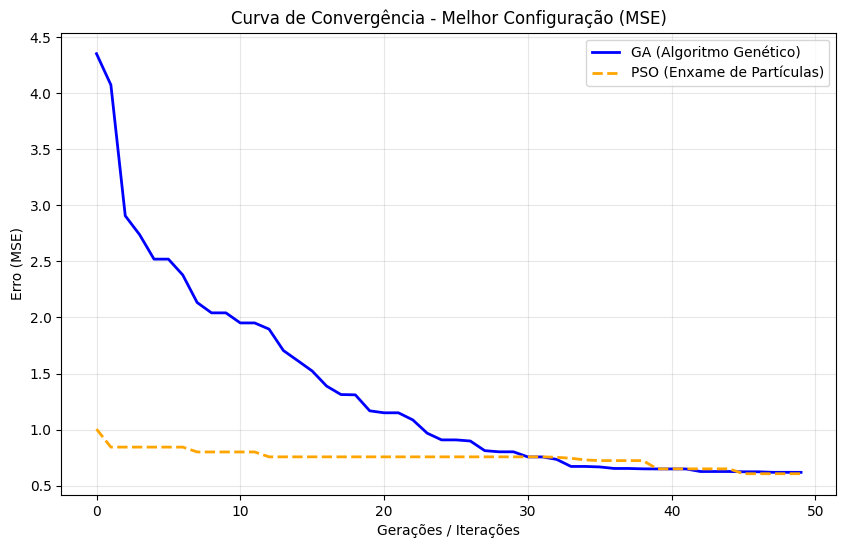

/tmp/ipython-input-4219018632.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algoritmo', y='Score_Teste', data=df_mean, palette=['skyblue', 'orange'])


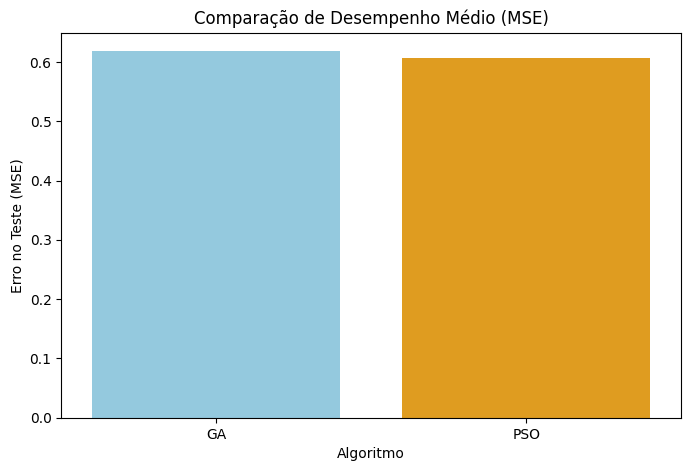

In [7]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ====================================================================
# 1. MÓDULO DE DADOS (dados_opt)
# ====================================================================

def carregar_dados_otimizacao():
    data = fetch_california_housing()
    X = data.data
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Bias
    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    return X_train, X_test, y_train, y_test

def calcular_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calcular_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# ====================================================================
# 2. MÓDULO ALGORITMO GENÉTICO (ga_opt)
# ====================================================================

class GeneticAlgorithm:
    def __init__(self, pop_size, mutation_rate, crossover_rate, n_genes, fun_avaliacao):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.n_genes = n_genes
        self.fun_avaliacao = fun_avaliacao
        self.population = []
        self.best_individual = None
        self.best_score = float('inf')
        self.history = []

    def init_population(self):
        self.population = np.random.uniform(-1, 1, (self.pop_size, self.n_genes))

    def fitness(self, individuo, X, y):
        y_pred = X.dot(individuo)
        return self.fun_avaliacao(y, y_pred)

    def select(self, scores):
        idx1 = random.randint(0, self.pop_size - 1)
        idx2 = random.randint(0, self.pop_size - 1)
        return self.population[idx1] if scores[idx1] < scores[idx2] else self.population[idx2]

    def crossover(self, pai1, pai2):
        if random.random() < self.crossover_rate:
            point = random.randint(1, self.n_genes - 1)
            return np.concatenate([pai1[:point], pai2[point:]]), np.concatenate([pai2[:point], pai1[point:]])
        return pai1.copy(), pai2.copy()

    def mutate(self, individuo):
        for i in range(self.n_genes):
            if random.random() < self.mutation_rate:
                individuo[i] += np.random.normal(0, 0.1)
        return individuo

    def run(self, X, y, generations=50):
        self.init_population()
        self.best_score = float('inf')
        self.history = []

        for generation in range(generations):
            scores = [self.fitness(ind, X, y) for ind in self.population]

            min_score = min(scores)
            if min_score < self.best_score:
                self.best_score = min_score
                self.best_individual = self.population[scores.index(min_score)].copy()

            self.history.append(self.best_score)

            new_pop = [self.best_individual] # Elitismo
            while len(new_pop) < self.pop_size:
                pai1 = self.select(scores)
                pai2 = self.select(scores)
                f1, f2 = self.crossover(pai1, pai2)
                new_pop.append(self.mutate(f1))
                if len(new_pop) < self.pop_size: new_pop.append(self.mutate(f2))
            self.population = np.array(new_pop)

        return self.best_score, self.best_individual, self.history

# ====================================================================
# 3. MÓDULO PSO (pso_opt)
# ====================================================================

class PSO:
    def __init__(self, n_particles, c1, c2, n_dim, fun_avaliacao, w=0.7):
        self.n_particles = n_particles
        self.c1 = c1; self.c2 = c2; self.w = w
        self.n_dim = n_dim
        self.fun_avaliacao = fun_avaliacao
        self.positions = np.random.uniform(-1, 1, (n_particles, n_dim))
        self.velocities = np.zeros((n_particles, n_dim))
        self.p_best_pos = self.positions.copy()
        self.p_best_scores = np.full(n_particles, float('inf'))
        self.g_best_pos = None
        self.g_best_score = float('inf')
        self.history = []

    def run(self, X, y, iterations=50):
        self.history = []
        # Avaliação Inicial
        for i in range(self.n_particles):
            score = self.fun_avaliacao(y, X.dot(self.positions[i]))
            if score < self.p_best_scores[i]:
                self.p_best_scores[i] = score
                self.p_best_pos[i] = self.positions[i]
            if score < self.g_best_score:
                self.g_best_score = score
                self.g_best_pos = self.positions[i]

        for it in range(iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.random(self.n_dim), np.random.random(self.n_dim)
                cog = self.c1 * r1 * (self.p_best_pos[i] - self.positions[i])
                soc = self.c2 * r2 * (self.g_best_pos - self.positions[i])
                self.velocities[i] = self.w * self.velocities[i] + cog + soc
                self.positions[i] += self.velocities[i]

                score = self.fun_avaliacao(y, X.dot(self.positions[i]))
                if score < self.p_best_scores[i]:
                    self.p_best_scores[i] = score
                    self.p_best_pos[i] = self.positions[i]
                if score < self.g_best_score:
                    self.g_best_score = score
                    self.g_best_pos = self.positions[i]
            self.history.append(self.g_best_score)

        return self.g_best_score, self.g_best_pos, self.history

# ====================================================================
# 4. MÓDULO DE GRÁFICOS (graficos_opt) - NOVO!
# ====================================================================

def plotar_convergencia(hist_ga, hist_pso, metrica_nome):
    """Plota a curva de evolução do erro ao longo das gerações/iterações."""
    plt.figure(figsize=(10, 6))
    plt.plot(hist_ga, label='GA (Algoritmo Genético)', color='blue', linewidth=2)
    plt.plot(hist_pso, label='PSO (Enxame de Partículas)', color='orange', linewidth=2, linestyle='--')

    plt.title(f'Curva de Convergência - Melhor Configuração ({metrica_nome})')
    plt.xlabel('Gerações / Iterações')
    plt.ylabel(f'Erro ({metrica_nome})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plotar_comparacao_barras(df_resultados, metrica_alvo='MSE'):
    """Plota gráfico de barras comparando GA vs PSO."""
    df_filtrado = df_resultados[df_resultados['Metrica'] == metrica_alvo]

    # Agrupar para pegar a média
    df_mean = df_filtrado.groupby('Algoritmo')[['Score_Teste']].mean().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Algoritmo', y='Score_Teste', data=df_mean, palette=['skyblue', 'orange'])
    plt.title(f'Comparação de Desempenho Médio ({metrica_alvo})')
    plt.ylabel(f'Erro no Teste ({metrica_alvo})')
    plt.show()

# ====================================================================
# 5. EXECUÇÃO PRINCIPAL
# ====================================================================

if __name__ == '__main__':
    # Configurações
    X_train, X_test, y_train, y_test = carregar_dados_otimizacao()
    n_features = X_train.shape[1]

    experimentos_ga = [{'id': 1, 'pop': 50, 'mut': 0.1, 'cross': 0.8}] # Simplificado para demo
    experimentos_pso = [{'id': 1, 'pop': 50, 'c1': 1.5, 'c2': 1.5}]    # Simplificado para demo

    # Variáveis para guardar o histórico do MELHOR modelo para plotagem
    melhor_hist_ga = []
    melhor_hist_pso = []

    resultados = []

    print("--- Executando GA ---")
    ga = GeneticAlgorithm(pop_size=50, mutation_rate=0.1, crossover_rate=0.8,
                          n_genes=n_features, fun_avaliacao=calcular_mse)
    _, _, hist_ga = ga.run(X_train, y_train, generations=50)
    melhor_hist_ga = hist_ga
    resultados.append({'Algoritmo': 'GA', 'Metrica': 'MSE', 'Score_Teste': hist_ga[-1]})

    print("--- Executando PSO ---")
    pso = PSO(n_particles=50, c1=1.5, c2=1.5, n_dim=n_features, fun_avaliacao=calcular_mse)
    _, _, hist_pso = pso.run(X_train, y_train, iterations=50)
    melhor_hist_pso = hist_pso
    resultados.append({'Algoritmo': 'PSO', 'Metrica': 'MSE', 'Score_Teste': hist_pso[-1]})

    # --- CHAMADA DO MÓDULO DE GRÁFICOS ---
    print("\nGerando Gráficos...")

    # 1. Gráfico de Convergência
    plotar_convergencia(melhor_hist_ga, melhor_hist_pso, 'MSE')

    # 2. Gráfico de Comparação
    df_res = pd.DataFrame(resultados)
    plotar_comparacao_barras(df_res, 'MSE')